In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

Functions

In [2]:
## image convolute with a kernel
def apply_filter(image, kernel):
    return convolve2d(image, kernel, mode='same', boundary='wrap')

In [3]:
## convert image to grayscale
def grayscale_image(image):
    coefficients = np.array([0.21, 0.72, 0.07])
    gray_image = np.dot(image, coefficients)
    print(gray_image.shape)
    return gray_image.astype(np.uint8)

In [4]:
## generate gaussian kernel and normalize the kernal
def get_gaussian_kernel(size, sigma=1.0):
    kernel = np.fromfunction(
        lambda x, y: (1/ (2*np.pi*sigma**2)) * 
                    np.exp(- ((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2*sigma**2)),
        (size, size)
    )
    gaussian_kernel =  kernel / np.sum(kernel)
    return gaussian_kernel

In [5]:
## get the gradients
def gradient_estimation(image):
    sobel_Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_My = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    x_gradient = apply_filter(image,sobel_Mx)
    y_gradient = apply_filter(image,sobel_My)
    
    ## | | = (x**2 + y**2)^0.5
    ## anggle = tan-(y/x)
    gradient_strength = np.sqrt(x_gradient**2 + y_gradient**2)
    gradient_direction = np.arctan2(y_gradient, x_gradient)
    
    return gradient_strength, gradient_direction

In [6]:
def non_maxima_suppression(image,gradient_strength,gradient_direction):
    Y,X = image.shape
    
    for x in range(X): 
        for y in range(Y): 
            
            ## get the direction of gradient
            angle = gradient_direction[y, x] 
            angle = abs(angle-180) if abs(angle)>180 else abs(angle) 
              
            ## get the neighbor pixel   
            if angle<= 22.5: 
                neighb_1_x, neighb_1_y = x-1, y 
                neighb_2_x, neighb_2_y = x + 1, y 
              
            elif angle>22.5 and angle<=(22.5 + 45): 
                neighb_1_x, neighb_1_y = x-1, y-1
                neighb_2_x, neighb_2_y = x + 1, y + 1
              
            elif angle>(22.5 + 45) and angle<=(22.5 + 90): 
                neighb_1_x, neighb_1_y = x, y-1
                neighb_2_x, neighb_2_y = x, y + 1
              
            elif angle>(22.5 + 90) and angle<=(22.5 + 135): 
                neighb_1_x, neighb_1_y = x-1, y + 1
                neighb_2_x, neighb_2_y = x + 1, y-1
              
            elif angle>(22.5 + 135) and angle<=(22.5 + 180): 
                neighb_1_x, neighb_1_y = x-1, y 
                neighb_2_x, neighb_2_y = x + 1, y 
             
            ## remove gradient if the gradient is not maximum in [y,x]
            if X>neighb_1_x>= 0 and Y>neighb_1_y>= 0: 
                if gradient_strength[y, x]<gradient_strength[neighb_1_y, neighb_1_x]: 
                    gradient_strength[y, x]= 0
                    continue
   
            if X>neighb_2_x>= 0 and Y>neighb_2_y>= 0: 
                if gradient_strength[y, x]<gradient_strength[neighb_2_y, neighb_2_x]: 
                    gradient_strength[y, x]= 0
                    
    return gradient_strength
    

In [7]:
def double_threshold(image,gradient_strength,lower_fraction,upper_fraction):
    indexes = np.zeros_like(image)
    Y,X = image.shape
    maximum_magnitude = np.max(gradient_strength)
    lower_threshold = maximum_magnitude * lower_fraction
    upper_threshold = maximum_magnitude * upper_fraction
    for x in range(X): 
        for y in range(Y): 
              
            gradient_magnitude = gradient_strength[y, x] 
              
            if gradient_magnitude<lower_threshold: 
                gradient_strength[y, x]= 0
            elif upper_threshold>gradient_magnitude>= lower_threshold: 
                gradient_strength[y, x]= 128
            else: 
                gradient_strength[y, x]= 255
    
    # check the neighbors values
    gradient_strong = np.zeros(gradient_strength.shape)
    for x in range(X):
        for y in range(Y):
            val = gradient_strength[y,x]
            if val == 128:
                if (x+1 < X and y+1 < Y and (gradient_strength[y-1,x] == 255 or gradient_strength[y+1,x] == 255 or gradient_strength[y-1,x-1] == 255 or gradient_strength[y+1,x-1] == 255 or gradient_strength[y-1,x+1] == 255 or gradient_strength[y+1,x+1] == 255 or gradient_strength[y,x-1] == 255 or gradient_strength[y,x+1] == 255)):
                    gradient_strong[y,x] = 255
                elif (x+1 < X and (gradient_strength[y-1,x] == 255 or gradient_strength[y-1,x-1] == 255 or gradient_strength[y-1,x+1] == 255 or gradient_strength[y,x-1] == 255 or gradient_strength[y,x+1] == 255)):
                    gradient_strong[y,x] = 255
                elif (y+1 < Y and (gradient_strength[y-1,x] == 255 or gradient_strength[y+1,x] == 255 or gradient_strength[y-1,x-1] == 255 or gradient_strength[y+1,x-1] == 255 or gradient_strength[y,x-1] == 255 )):
                    gradient_strong[y,x] = 255    
                elif (gradient_strength[y-1,x] == 255  or gradient_strength[y-1,x-1] == 255 or gradient_strength[y,x-1] == 255 ):
                    gradient_strong[y,x] = 255     
            elif val == 255:
                gradient_strong[y,x] = 255   
    return gradient_strong 

Import image

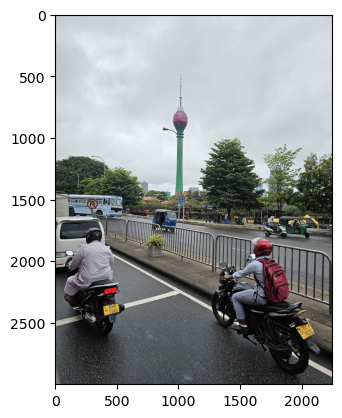

In [8]:
image = cv2.imread('image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Convert to Grayscale

(3000, 2250)


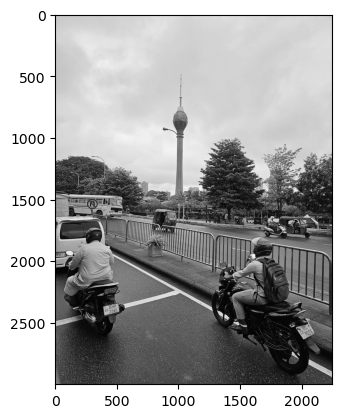

In [9]:
gray_image = grayscale_image(image)
plt.imshow(gray_image,cmap='gray')
cv2.imwrite('gray_image.jpg', gray_image)
plt.show()

Get gaussian kernel

In [10]:
gaussian_kernel = get_gaussian_kernel(3,1)
gaussian_kernel

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

Applying gaussian kernel

[[174.45338246 178.71251613 179.50833618 ... 163.66082297 165.48801438
  169.14007252]
 [198.3703431  197.         197.         ... 202.         202.
  200.6296569 ]
 [198.3703431  197.         197.         ... 202.         202.
  200.6296569 ]
 ...
 [113.58917522 131.60208998 133.37674915 ...  59.26868523  67.767072
   87.37356955]
 [112.07359045 131.         133.25290775 ...  57.66557258  66.72490871
   85.87886287]
 [135.59550378 148.7605075  150.66945797 ...  99.85334128 105.81167847
  118.1421864 ]]


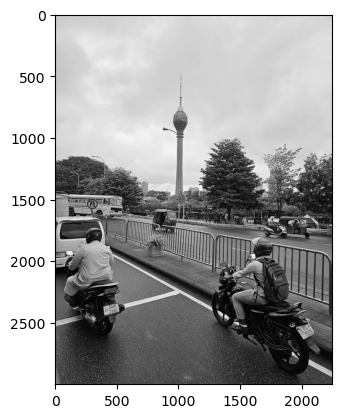

In [11]:
blured_image = apply_filter(gray_image,gaussian_kernel)
print(blured_image)
plt.imshow(blured_image,cmap='gray')
cv2.imwrite('blured_image.jpg', blured_image)
plt.show()

Get gradient strengths and directions

In [12]:
gradient_strength, gradient_direction = gradient_estimation(blured_image)
print(gradient_strength.shape,gradient_direction.shape)

(3000, 2250) (3000, 2250)


Apply non maxiama suppression

In [13]:
gradient_strength_1 = np.copy(gradient_strength)
gradient_strength_1 = non_maxima_suppression(blured_image,gradient_strength_1,gradient_direction)

Checking gradient threshold 

In [14]:
lower_fraction,upper_fraction = 0.1,0.3
gradient_strength_2= np.copy(gradient_strength_1)
gradient_strength_2 = double_threshold(blured_image,gradient_strength_2,lower_fraction,upper_fraction)

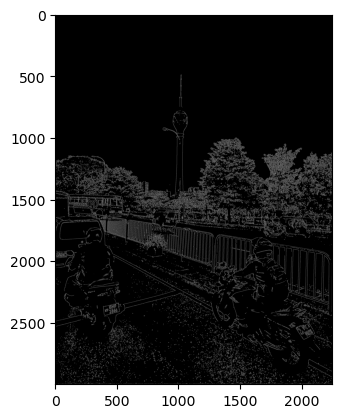

In [15]:
plt.imshow(gradient_strength_2,cmap='gray')
cv2.imwrite('output.jpg', gradient_strength_2)
plt.show()